##AutoRegressive Process

So we went through our guidline untill figuring out whether Moving Average is going to be handy or not. But what if ACF plot wont abruptly be non siginificant after a lag? Here is the updated guidline:

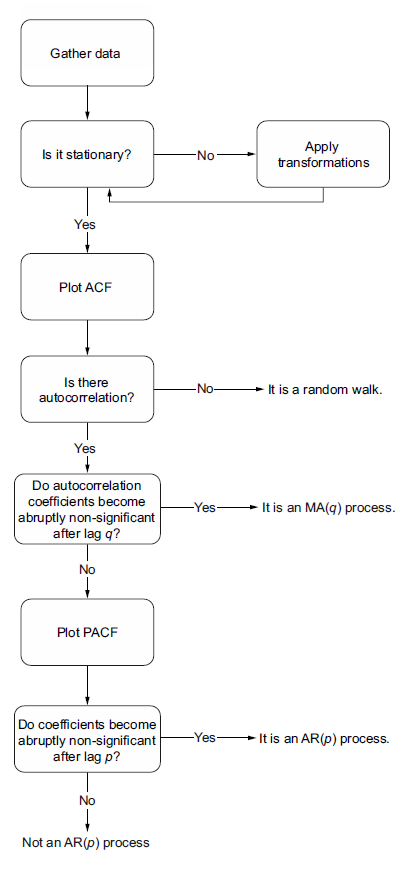

Let's begin.

###Import Data

Data is provided from url below:
https://github.com/marcopeix/TimeSeriesForecastingInPython/blob/master/data

In [1]:
import pandas as pd
df = pd.read_csv('/content/foot_traffic.csv')
df.head()

,foot_traffic
0,500.496714
1,500.522366
2,501.426876
3,503.295990
4,504.132695


###Visualization:

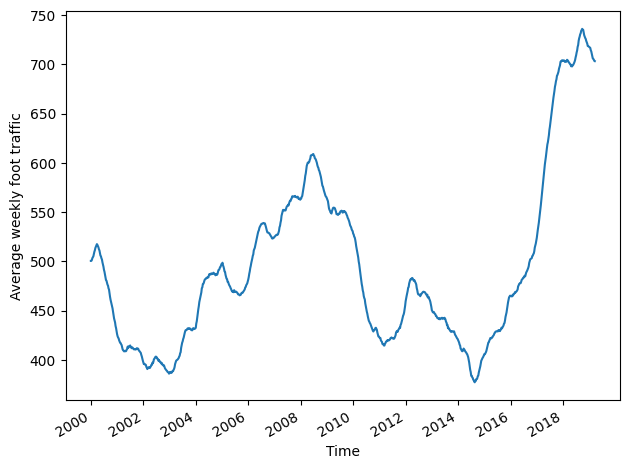

In [3]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()
ax.plot(df['foot_traffic'])
ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic')
plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))
fig.autofmt_xdate()
plt.tight_layout()

###ADF test of stationarity:

In [4]:
from statsmodels.tsa.stattools import adfuller
ADF_result = adfuller(df['foot_traffic'])
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -1.1758885999240747
p-value: 0.683880891789619


Due to the trends in our diagram, it is obvious that the data is not stationary and we accept null hypothesis.

###Transformation:

In [6]:
import numpy as np
foot_traffic_diff = np.diff(df['foot_traffic'], n=1)

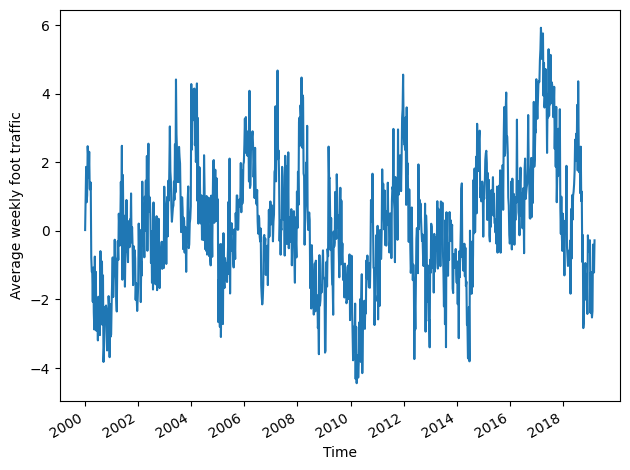

In [7]:
fig, ax = plt.subplots()
ax.plot(foot_traffic_diff)
ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic')
plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))
fig.autofmt_xdate()
plt.tight_layout()

We are successful in terms of eliminating trend so now we check if it is stationary:

In [8]:
ADF_result = adfuller(foot_traffic_diff)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -5.268231347422044
p-value: 6.369317654781239e-06


Here we are. Now we are going for ACF plotting as always:

###ACF Plotting

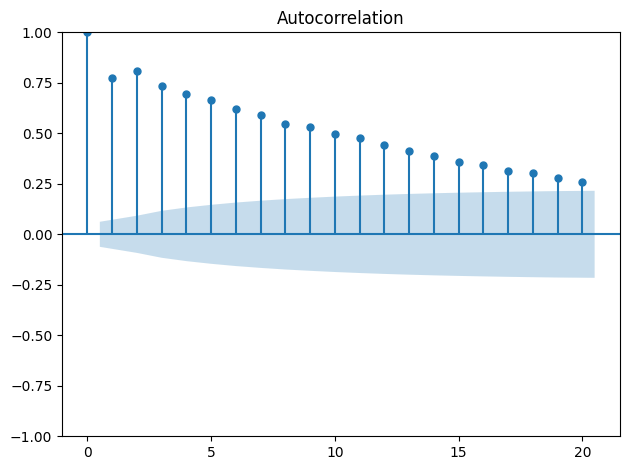

In [9]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(foot_traffic_diff, lags=20);
plt.tight_layout()

We see that we are not facing a random walk but on the other hand it is not aburptly descresing and it decaying exponentially. This is a sign we are facing autoregressive process. But in order the find the order of it we have to find a better way and that is Partial AutoCorrolation Function (PACF) plot.By PACF we are actually remove the confounding values influnace to calculate yt value. In other word to just see the corrolation between today value and a value in past without the engagement of any other variable between.

###Data Creation for AR(2)

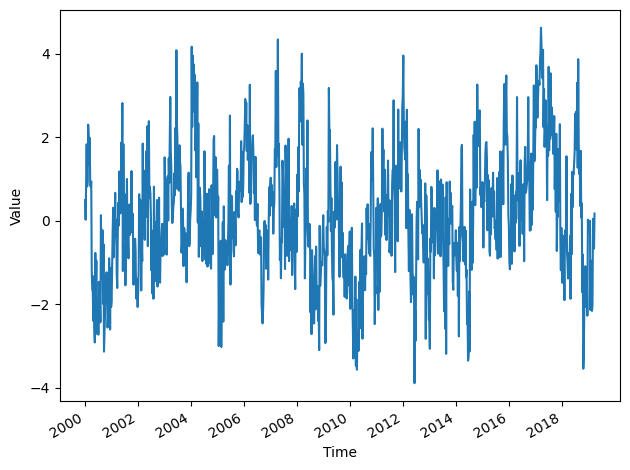

In [10]:
from statsmodels.tsa.arima_process import ArmaProcess
import numpy as np
np.random.seed(42)
ma2 = np.array([1, 0, 0])
ar2 = np.array([1, -0.33, -0.50])# we are making a yt = 0.33yt-1 + 0.5yt-2 without MA process coefficient
AR2_process = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)
fig, ax = plt.subplots()
ax.plot(AR2_process)
ax.set_xlabel('Time')
ax.set_ylabel('Value')
plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))
fig.autofmt_xdate()
plt.tight_layout()

###Plot PACF

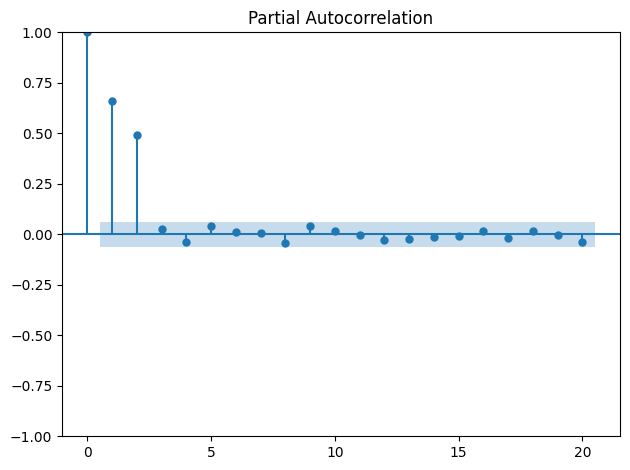

In [11]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(AR2_process, lags=20);
plt.tight_layout()

Back to our dataset, lets see what order is our autoregressive process:

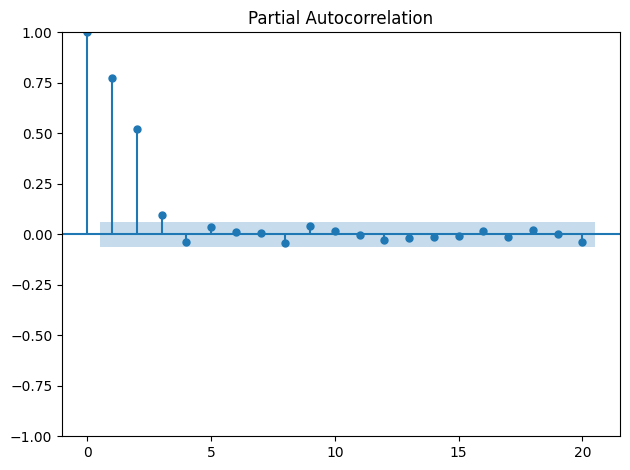

In [12]:
plot_pacf(foot_traffic_diff, lags=20);
plt.tight_layout()

According to the PACF plot we are facing the order of 3 for our AR.

###Train-Test Split

In [13]:
df_diff = pd.DataFrame({'foot_traffic_diff': foot_traffic_diff})
train = df_diff[:-52]
test = df_diff[-52:]
print(len(train))
print(len(test))

947
52


###Check period to forecast

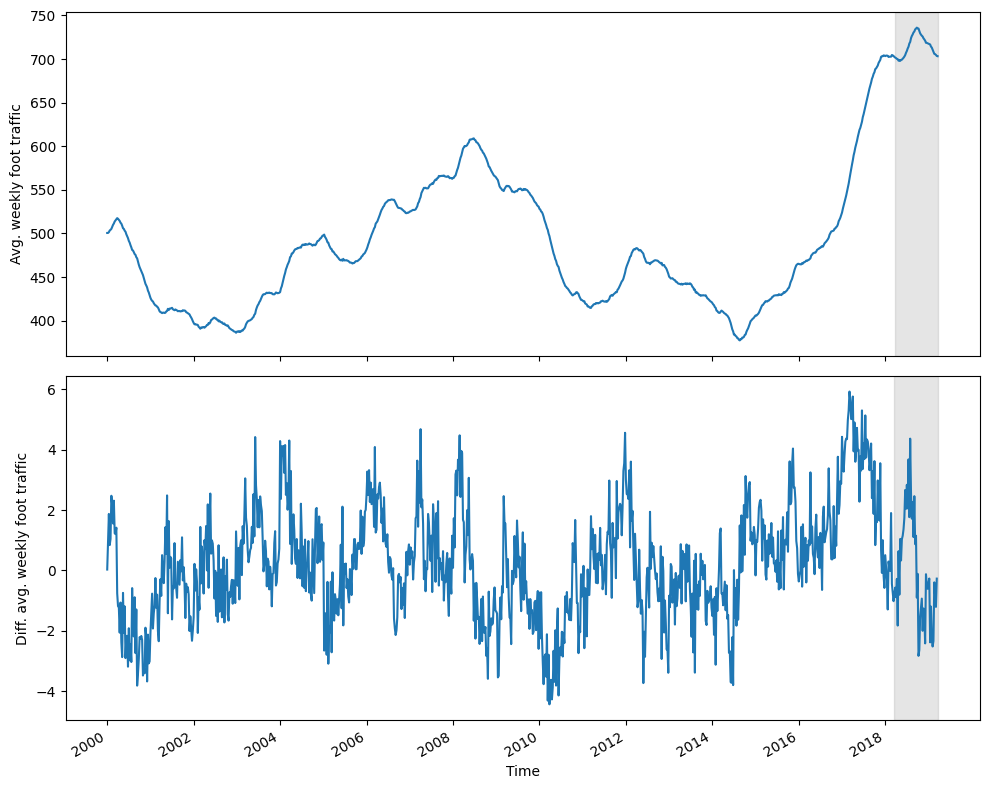

In [14]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))
ax1.plot(df['foot_traffic'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Avg. weekly foot traffic')
ax1.axvspan(948, 1000, color='#808080', alpha=0.2)
ax2.plot(df_diff['foot_traffic_diff'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Diff. avg. weekly foot traffic')
ax2.axvspan(947, 999, color='#808080', alpha=0.2)
plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))
fig.autofmt_xdate()
plt.tight_layout()

###Rolling Forecast Function Defenition

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
  total_len = train_len + horizon
  end_idx = train_len
  if method == 'mean':
    pred_mean = []
    for i in range(train_len, total_len, window):
      mean = np.mean(df[:i].values)
      pred_mean.extend(mean for _ in range(window))
    return pred_mean
  elif method == 'last':
    pred_last_value = []
    for i in range(train_len, total_len, window):
      last_value = df[:i].iloc[-1].values[0]
      pred_last_value.extend(last_value for _ in range(window))
    return pred_last_value
  elif method == 'AR':
    pred_AR = []
    for i in range(train_len, total_len, window):
      model = SARIMAX(df[:i], order=(3,0,0)) #The order specifies an AR(3) model.
      res = model.fit(disp=False)
      predictions = res.get_prediction(0, i + window - 1)
      oos_pred = predictions.predicted_mean.iloc[-window:]
      pred_AR.extend(oos_pred)
    return pred_AR

###Forecast with autoregressive and naive methods:

In [20]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1
pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean');
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last');
pred_AR = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'AR');
test['pred_mean'] = pred_mean;
test['pred_last_value'] = pred_last_value;
test['pred_AR'] = pred_AR;
test.head()

<ipython-input-20-fc1dc379143d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred_mean'] = pred_mean;
<ipython-input-20-fc1dc379143d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred_last_value'] = pred_last_value;
<ipython-input-20-fc1dc379143d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

,foot_traffic_diff,pred_mean,pred_last_value,pred_AR
947,-0.776601,0.213270,-1.021893,-0.719714
948,-0.574631,0.212226,-0.776601,-0.814547
949,-0.890697,0.211397,-0.574631,-0.664738
950,-0.283552,0.210237,-0.890697,-0.641469
951,-1.830685,0.209717,-0.283552,-0.579279


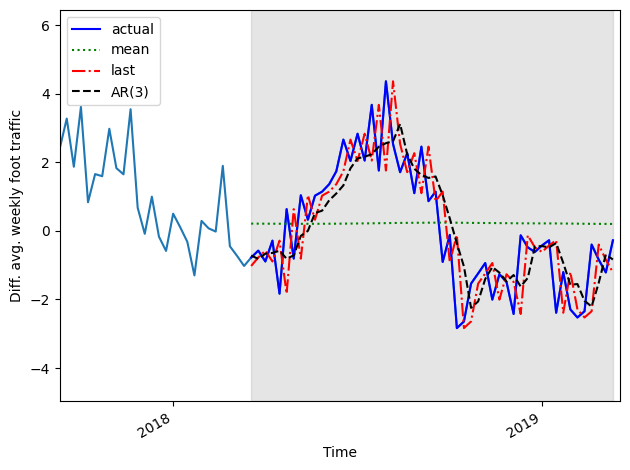

In [21]:
fig, ax = plt.subplots()
ax.plot(df_diff['foot_traffic_diff'])
ax.plot(test['foot_traffic_diff'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_AR'], 'k--', label='AR(3)')
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Diff. avg. weekly foot traffic')
ax.axvspan(947, 998, color='#808080', alpha=0.2)
ax.set_xlim(920, 999)
plt.xticks([936, 988],[2018, 2019])
fig.autofmt_xdate()
plt.tight_layout()

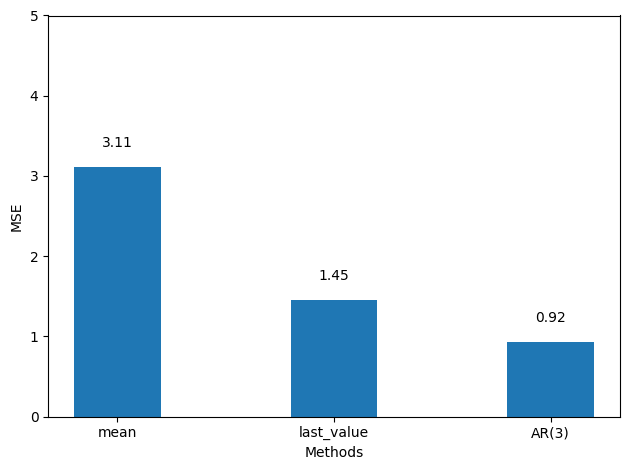

In [33]:
from sklearn.metrics import mean_squared_error
mse_mean = mean_squared_error(test['foot_traffic_diff'], test['pred_mean'])
mse_last = mean_squared_error(test['foot_traffic_diff'], test['pred_last_value'])
mse_AR = mean_squared_error(test['foot_traffic_diff'], test['pred_AR'])
x = ['mean', 'last_value', 'AR(3)']
y = [mse_mean, mse_last, mse_AR]

fig, ax = plt.subplots()
ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 5)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()

In [35]:
df['pred_foot_traffic'] = pd.Series()
df['pred_foot_traffic'][948:] = df['foot_traffic'].iloc[948] + test['pred_AR'].cumsum();

<ipython-input-35-21e0c221f7c3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_foot_traffic'][948:] = df['foot_traffic'].iloc[948] + test['pred_AR'].cumsum();


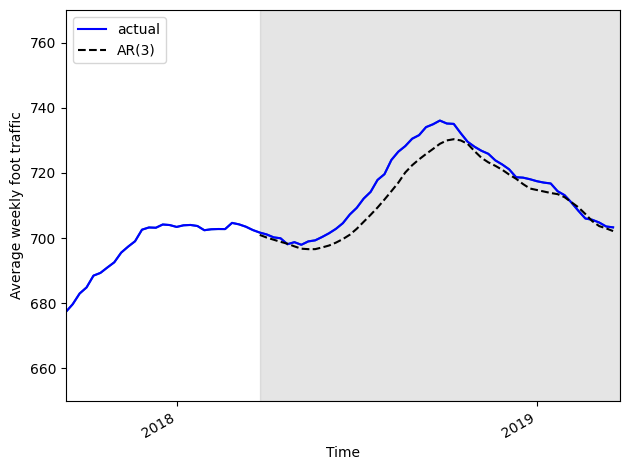

In [36]:
fig, ax = plt.subplots()

ax.plot(df['foot_traffic'])
ax.plot(df['foot_traffic'], 'b-', label='actual')
ax.plot(df['pred_foot_traffic'], 'k--', label='AR(3)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic')

ax.axvspan(948, 1000, color='#808080', alpha=0.2)

ax.set_xlim(920, 1000)
ax.set_ylim(650, 770)

plt.xticks([936, 988],[2018, 2019])

fig.autofmt_xdate()
plt.tight_layout()

In [37]:
from sklearn.metrics import mean_absolute_error

mae_AR_undiff = mean_absolute_error(df['foot_traffic'][948:], df['pred_foot_traffic'][948:])

print(mae_AR_undiff)

3.478033559658852
